In [1]:
import numpy as np
import random

def carve_passages_from(maze, x, y):
    maze[y, x] = 0
    directions = [(0, -2), (0, 2), (-2, 0), (2, 0)]
    random.shuffle(directions)

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 < nx < maze.shape[1] and 0 < ny < maze.shape[0] and maze[ny, nx] == 1:
            maze[y + dy//2, x + dx//2] = 0
            carve_passages_from(maze, nx, ny)

def generate_maze(width, height):
    if width % 2 == 0 or height % 2 == 0:
        raise ValueError("Width and height must be odd.")

    maze = np.ones((height, width), dtype=int)
    start = (1, 0)
    end = (height - 2, width - 1)

    maze[start[0], start[1]] = 0
    maze[end[0], end[1]] = 0

    carve_passages_from(maze, random.randrange(1, width, 2), random.randrange(1, height, 2))

    return maze

def save_mazes_to_file(filename, num_mazes, width, height):
    with open(filename, 'w') as file:
        for i in range(num_mazes):
            maze = generate_maze(width, height)
            for row in maze:
                file.write(" ".join(str(cell) for cell in row) + "\n")
            file.write("\n")

width, height = 31, 31
save_mazes_to_file("output", 1, width, height)
maze = generate_maze(width, height)
print(maze)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1]
 [1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1]
 [1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1]
 [1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
 [1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1]
 [1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1]
 [1 0 0 0 1 0 0 0 0 0 1 0

Ant Colony Optimization

In [3]:
def ant_colony_optimization(maze, start, end, num_ants=10, num_iterations=100, evaporation_rate=0.5, alpha=1, beta=1, max_path_length=1000):
    height, width = maze.shape
    pheromone = np.ones((height, width))
    best_path = None
    best_path_length = float('inf')

    for _ in range(num_iterations):
        paths = []
        path_lengths = []

        for ant in range(num_ants):
            current_position = start
            path = [current_position]
            path_length = 0

            while current_position != end and path_length < max_path_length:
                y, x = current_position
                neighbors = []
                probabilities = []

                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width and maze[ny, nx] == 0:
                        neighbors.append((ny, nx))
                        pheromone_level = pheromone[ny, nx]
                        distance = abs(ny - end[0]) + abs(nx - end[1])
                        if distance == 0:
                            probability = 1.0  # Максимальная вероятность, если это финиш
                        else:
                            probability = (pheromone_level ** alpha) * ((1 / distance) ** beta)
                        probabilities.append(probability)

                if not neighbors:
                    break  # Муравей застрял в тупике

                probabilities = np.array(probabilities)
                probabilities /= probabilities.sum()

                next_position = neighbors[np.random.choice(len(neighbors), p=probabilities)]
                path.append(next_position)
                path_length += 1
                current_position = next_position

            if current_position == end:
                paths.append(path)
                path_lengths.append(path_length)

                if path_length < best_path_length:
                    best_path = path
                    best_path_length = path_length

        # Обновление феромонов
        pheromone *= evaporation_rate

        for path, path_length in zip(paths, path_lengths):
            for y, x in path:
                pheromone[y, x] += 1 / path_length

    return best_path

# Пример использования
start = (1, 0)
end = (height - 2, width - 1)

solution_path = ant_colony_optimization(maze, start, end)

if solution_path:
    print("Решение найдено:")
    #for y, x in solution_path:
    #    print(f"({y}, {x})")
else:
    print("Решение не найдено.")

Решение найдено:


Visualization

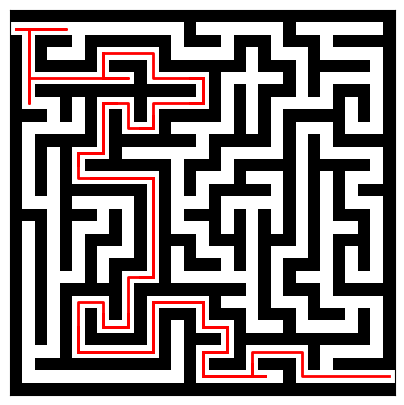

In [4]:
import matplotlib.pyplot as plt

def plot_maze_with_path(maze, path):
    plt.figure(figsize=(5, 5))
    plt.imshow(maze, cmap='binary')
    if path:
        y_coords, x_coords = zip(*path)
        plt.plot(x_coords, y_coords, color='red', linewidth=2)
    plt.xticks([]), plt.yticks([])
    plt.show()

plot_maze_with_path(maze, solution_path)